In [13]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv("..\data_preprocessing\processed_dataset.csv")
df.head()
print(df['sentiment'].value_counts())
df = df.dropna(subset=['cleaned_review', 'sentiment'])

X = df['cleaned_review']
y = df['sentiment']

sentiment
positive    307625
negative     48822
neutral      28070
Name: count, dtype: int64


In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to("cuda")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

k:\Computer Science\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\krish\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
def get_bert_embeddings(text_list):
    # Tokenize and get embeddings in batches
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the CLS token's embedding as the sentence embedding
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

In [5]:
X_embeddings = np.array([get_bert_embeddings([text])[0] for text in X])
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

In [17]:
with open("bert_train_embeddings.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("bert_test_embeddings.pkl", "wb") as f:
    pickle.dump(X_test, f)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [15]:
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.14      0.23      9800
     neutral       0.25      0.02      0.04      5690
    positive       0.82      0.99      0.89     61376

    accuracy                           0.81     76866
   macro avg       0.55      0.38      0.39     76866
weighted avg       0.74      0.81      0.75     76866

Accuracy: 0.8064423802461427


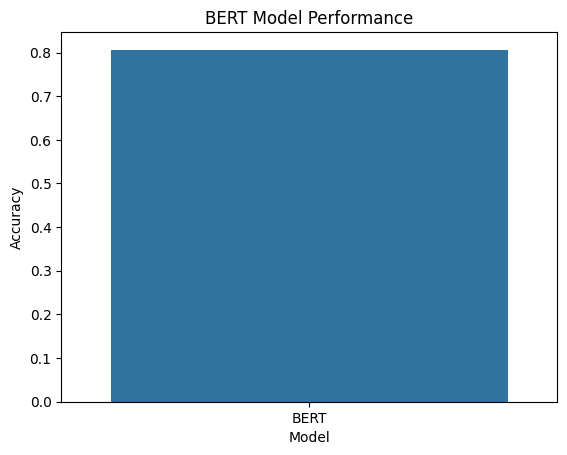

In [16]:
performance = pd.DataFrame({
    "Model": ["BERT"],
    "Accuracy": [accuracy_score(y_test, y_pred)]
})

sns.barplot(x="Model", y="Accuracy", data=performance)
plt.title("BERT Model Performance")
plt.show()